# Large-Scale Fading Models

Radio propagation models have a crucial role in the development of communication systems for practical use. They are essential for forecasting how a communication system will perform in various settings. This Notebook focuses on explaining the principles behind simulating various aspects of large-scale propagation models, including models like:
- The Free-Space Path Loss
- Log-Normal Shadowing 
- Hata-Okumura Models

There are other aspects like diffraction losses and ground reflections to be covered later

## Friis Free-Space Propagation Model

Friis free space propagation model is used to model the LOS path loss incurred in a free space environment,
devoid of any objects that create absorption, diffraction, reflections, or any other characteristic-altering phenomenon to a radiated wave. It is valid only in the far field region of the transmitting antenna and is based
on the inverse square law of distance which states that the received power at a particular distance from the
transmitter decays by a factor of square of the distance

$$P_r(d) = \frac{P_t G_t G_r \lambda^2}{(4\pi d)^2 L}$$
<small>

$P_r(d)$ is the received signal power in Watts expressed as a function of separation distance (d meters)
between the transmitter and the receiver 

$P_t$ is the power of the transmitted signal’s Watts 

$G_t \& G_r$ are the gains of transmitter and receiver antennas when compared to an isotropic radiator with unit gain

λ is the wavelength of carrier in meters 

L represents other losses that is not associated with the propagation loss. The parameter L may include system losses like loss at the antenna, transmission line attenuation, loss at
various filters etc. T
</small>

The Friis equation can be modified to accommodate different environments, on the reason that the received
signal decreases as the n
th power of distance, where the parameter n is the path-loss exponent (PLE) that takes
constant values depending on the environment that is modeled

$$P_r(d) = \frac{P_t G_t G_r \lambda^2}{(4\pi)^2 d^n L}$$

<center>

![SNOWFALL](imgs/1.1.png)

</center>

The alternative form of Friis equation in log scale is given by

$$[P_r(d)]_{\text{dBm}} = [P_t]_{\text{dBm}} + [G_t]_{\text{dBi}} + [G_r]_{\text{dBi}} - [P_L]_{\text{dB}}$$

where $[P_L]_{\text{dB}}$ is the propagation path loss in free space

$$[P_L]_{\text{dB}} = 20 \cdot \log_{10}\left(\frac{\lambda}{4\pi}\right) - 10n \cdot \log_{10}(d) - 10 \cdot \log_{10}(L)$$

In [2]:
import numpy as np
import matplotlib, matplotlib.pyplot as plt

print('Matplotlib', matplotlib.__version__)
print('NumPy', np.__version__)

Matplotlib 3.7.2
NumPy 1.23.3


In [9]:
def friis_model(Pt_dBm,Gt_dBi,Gr_dBi,f,d,L,n):
    
    lmda = (3e8)/f #wavelength in meters
    gains = Gt_dBi + Gr_dBi # transmit & receive antenna gains
    PL_dB = (20*np.log10(lmda/(4*np.pi))) - (10*n*np.log10(d)) -(10 * np.log10(L)) #propagation path loss
    Pr_dBm = Pt_dBm + gains + PL_dB #received power

    return Pr_dBm

In [47]:
#inputs
Pt_dBm=0 #transmitted power in dBm

#"normalized antennas"
Gt_dBi = 1 #gain of the Transmitted antenna in dBi
Gr_dBi = 1 #Gain of the Receiver antenna in dBi

d_arr0 = 2 ** np.array([x for x in range(10)]) #array of input distances in meters
L = 1 #other System Losses, No Loss case L=1
freqs = [2.4e9, 5e9] #transmitted signal frequency in Hertz (2.4/5 GHz WiFi)
PLE = {"Free Space": 2, "Urban area cellular radio": 3, "Shadowed urban cellular radio": 4, 
       "Inside a building - line-of-sight": 1.7, "Obstructed in building": 5}

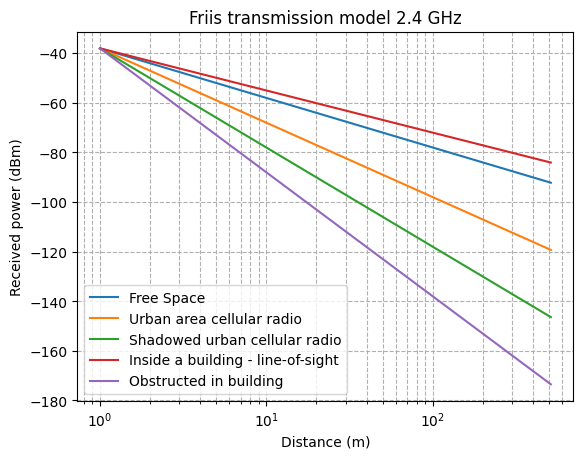

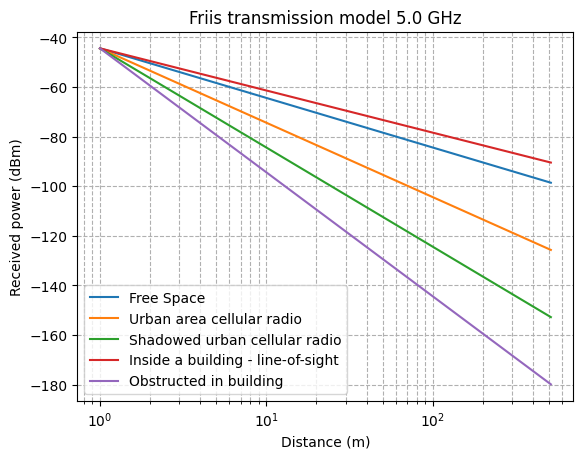

In [33]:
#plotting free-space path loss for WiFi frequencies for different path loss exponents
for f in freqs:
    plt.figure()
    for env, n in PLE.items():
        Pr_dBm = friis_model(Pt_dBm,Gt_dBi,Gr_dBi,f,d_arr0,L,n)
        plt.semilogx(d_arr0, Pr_dBm, label = env)

    plt.title("Friis transmission model " + str(f)[0] + "." + str(f)[1] + " GHz")
    plt.legend()
    plt.xlabel("Distance (m)")
    plt.ylabel("Received power (dBm)")
    plt.grid(True, which="both", ls="--")
    plt.show()

## Log-Normal Shadowing

Log-Normal Shadowing model is an extension to the Friis free space model. It is used to predict the propagation
loss for a wide range of environments, whereas, the Friis free space model is restricted to unobstructed clear
path between the transmitter and the receiver. The model encompasses random shadowing effects due to signal
blockage by hills, trees, buildings etc.

In the far field region of the transmitter, for distances beyond $d_f$, if $P_L(d_0)$ is the path loss at a distance $d_0$
meters from the transmitter, then the path loss at an arbitrary distance $d > d_0$ is given by:

$$P_L(d)_{dB} = P_L(d_0)_{dB} + 10 n \cdot \log_{10} \left( \frac{d}{d_0} \right) + \chi , \quad d_f \leq d_0 < d$$

χ is a zero-mean Gaussian distributed random variable with standard deviation σ expressed in dB, used only when there is a shadowing effect.


In [61]:
def log_normal_shadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d,L,sigma,n):

    lmda = (3e8)/f #wavelength in meters
    gains = Gt_dBi + Gr_dBi # transmit & receive antenna gains
    K = (20*np.log10(lmda/(4*np.pi))) - (10*n*np.log10(d0)) -(10 * np.log10(L)) #propagation path loss  
    X = sigma * np.random.randn(len(d))  
    PL = gains + K - (10*n*np.log10(d/d0)) - X
    Pr_dBm = Pt_dBm + PL #received power

    return Pr_dBm

In [62]:
#inputs
sigma = 2 #standard deviation of log Normal distribution (in dB)
d0=1 #assume reference distance = 1m
d_arr1 = 100 * np.arange(1,100,0.2) #array of input distances in meters

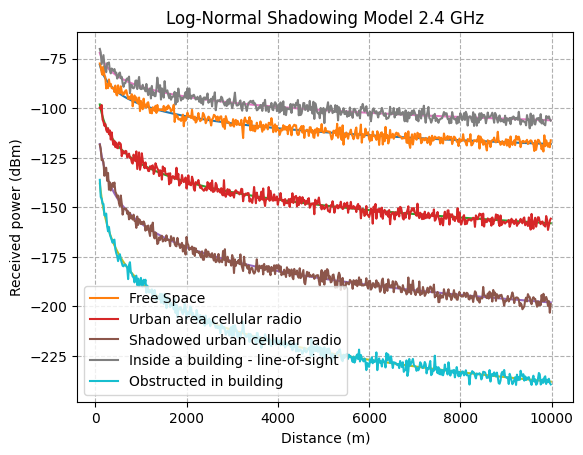

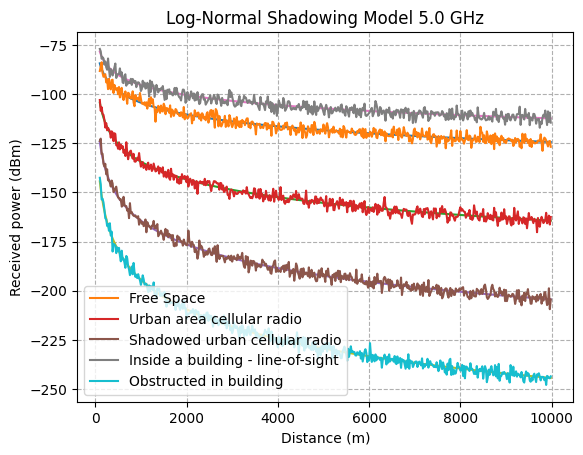

In [66]:
#plotting log-normal shadowing for WiFi frequencies for different path loss exponents
for f in freqs:
    plt.figure()
    for env, n in PLE.items():
        Pr_friis = friis_model(Pt_dBm,Gt_dBi,Gr_dBi,f,d_arr1,L,n)
        Pr_normal = log_normal_shadowing(Pt_dBm,Gt_dBi,Gr_dBi,f,d0,d_arr1,L,sigma,n)
        plt.plot(d_arr1, Pr_friis)
        plt.plot(d_arr1, Pr_normal, label = env)

    plt.title("Log-Normal Shadowing Model " + str(f)[0] + "." + str(f)[1] + " GHz")
    plt.legend()
    plt.xlabel("Distance (m)")
    plt.ylabel("Received power (dBm)")
    plt.grid(True, which="both", ls="--")
    plt.show()

## Hata-Okumura Model For Outdoor Propagation

Outdoor propagation models involve estimation of propagation loss over irregular terrains such as mountainous regions, simple curved earth profile, etc., with obstacles like trees and buildings. All such models predict
the received signal strength at a particular distance or on a small sector. These models vary in approach,
accuracy and complexity. Hata-Okumura model is one such model.

In 1986, Yoshihisa Okumura traveled around Tokyo city and made measurements for the signal attenuation
from base station to mobile station. He came up with a set of curves which gave the median attenuation relative
to free space path loss. Okumura came up with three set of data for three scenarios: open area, urban area and
sub-urban area. Okumura model can be adopted for computer simulations by digitizing those curves provided by Okumura and using them in the form
of look-up-tables.

Hata, in 1980, came up with closed form expressions based on curve fitting of Okumura models. It is the
most referred macroscopic propagation model. He extended the Okumura models to include effects due to
diffraction, reflection and scattering of transmitted signals by the surrounding structures in a city environment.

The received power level is given by:

$$[P_r(d)]_{\text{dBm}} = [P_t]_{\text{dBm}} + [G_t]_{\text{dBi}} - [P_L]_{\text{dB}}$$

The closed form expression for $[P_L]_{\text{dB}}$ is given by:

$$[P_L]_{\text{dB}} = A + B \log_{10} \left(d \right) + C$$

here, the Tx-Rx separation distance (d) is specified in kilometers (valid range 1 km to 20 Km). The factors
A,B,C depend on the frequency of transmission, antenna heights and the type of environment, as given next

$$A = 69.55 + 26.16 \log_{10}(f_c) - 13.82 \log_{10}(h_b) - a(h_m)$$

$$B = 44.9 - 6.55 \log_{10}(h_b)$$

- $f_c$ = frequency of transmission in MHz, valid range – 150 MHz to 1500 MHz
- $h_b$ = effective height of transmitting base station antenna in meters, valid range 30 m to 200 m
- $h_m$ = effective receiving mobile device antenna height in meters, valid range 1m to 10 m
- $a(h_m)$ = mobile antenna height correction factor that depends on the environment 
- C = a factor used to correct the formulas for open rural and suburban areas

Below the Hata model parameters ($a(h_m)$ & C) are tabulated:

<center>

![SNOWFALL](imgs/1.2.png)

</center>

In [97]:
def hata_model(fc,d,hb,hm,envtype):
    
    if (envtype == 0): #Metropolitan Area
        C = 0
        if (fc <= 200):
            aHm = 8.29 * ((np.log10(1.54*hm))**2) - 1.1
        else:
            aHm = 3.2 * ((np.log10(11.75*hm))**2) - 4.92
    elif (envtype == 1): #Suburban Area
        aHm = ((1.1*np.log10(fc)-0.7) * hm) - (1.56*np.log10(fc)-0.8)
        C = (-2 * (np.log10(fc/28))**2) - 5.4
    elif (envtype == 2): #Open Rural Area
        aHm = ((1.1*np.log10(fc)-0.7) * hm) - (1.56*np.log10(fc)-0.8)
        C = (-4.78*(np.log10(fc))**2) + (18.33*np.log10(fc)) - 40.98
    else:
        raise ValueError('Invalid model selection')

    A = 69.55 + (26.16*np.log10(fc)) - 13.82*np.log10(hb)-aHm
    B = 44.9 - (6.55*np.log10(hb))
    PL=A + (B*np.log10(d)) + C

    return PL

In [98]:
#inputs
d_arr2 = np.arange(1,20,0.1) #array of distances in km
fc = 1500 #carrier freq in MHz
hb = 70 #effective height of transmitter in m
hm = 1.5 #effective height of receiver in m
envtype = ['Metropolitan Area', 'Suburban Area', 'Open Rural Area']

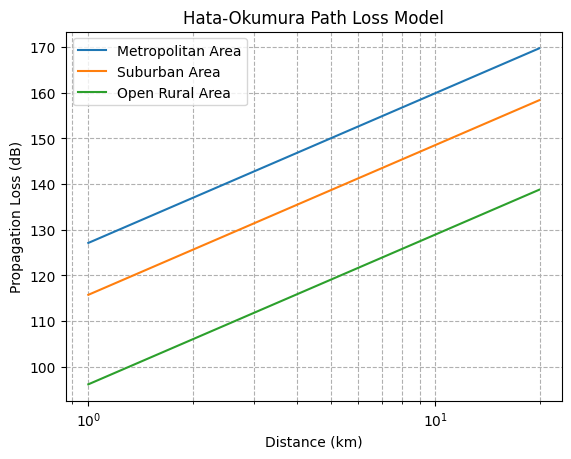

In [99]:
#plotting path loss for different environments using the Hata model
plt.figure()
for idx, env in enumerate(envtype):
    PL_hata = hata_model(fc,d_arr2,hb,hm,idx)
    plt.semilogx(d_arr2, PL_hata, label = env)

plt.title("Hata-Okumura Path Loss Model")
plt.legend()
plt.xlabel("Distance (km)")
plt.ylabel("Propagation Loss (dB)")
plt.grid(True, which="both", ls="--")
plt.show()